In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import wave, struct
from copy import deepcopy
from weighted_levenshtein import lev
import time

from scipy.io import wavfile


from Classifier.load_data import load_training_data

from Classifier.plot_data import plot_labelled_wave, plot_predictions, plot_detection_errors

from Classifier.classifier import streaming_classifier, zeroes_classifier


In [2]:

waves, labels, samprate = load_training_data(path = "Datasets/",
                                             scale_factor= 1,
                                             blacklist = [],
                                             whitelist = ["data"])



dict_keys(['data0', 'data1', 'data2', 'data3', 'data4', 'data5']) dict_keys(['data0', 'data1', 'data2', 'data3', 'data4', 'data5'])
c:\Users\darap\Documents\School\University\2021, Sem. 1\DATA3888\Aqua10\Classifier\load_data.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels_dat = pd.read_csv(path+file, sep=",\t", skiprows=1)


In [5]:
# ASSUMES THAT HEIGHT_THRESHOLD AND CONSECUTIVE_SAMPLES_THRESHOLD ARE INDEPENDENT

# Set parameters such that event detection window lands in the middle of the signal

window_size = 0.652513


det_window = 0.45


hyp_detection_buffer_end = (window_size - det_window)/2

hyp_detection_buffer_start = (window_size - det_window)/2

N_loops_over_window = 9 #Change
buffer_size = window_size / N_loops_over_window

hyp_consecutive_triggers = int(np.ceil(det_window/buffer_size))
#print(hyp_consecutive_triggers)




# fig, ax = plt.subplots(len(waves), 1)
# fig.set_size_inches(15, 3*len(waves))



all_accuracies = {}

#CONSEC OPTIMISATION
for i in range(1, 100, 1):
    current_accuracies = []
    height_threshold = i
    print(i)
    for i, key in enumerate(waves):
        predictions, predictions_timestamps, predictions_storage = streaming_classifier(
            waves[key], # Either the array from file (or ser if live = True)
            samprate,
            classifier = zeroes_classifier, 
            using_zeroes_classifier = True,
            zeroes_height_threshold = i,
            zeroes_consec_threshold = 0.02,
            window_size = window_size, # Total detection window [s]
            N_loops_over_window = N_loops_over_window, # implicitly defines buffer to be 1/x of the window
            #CHANGE
            hyp_detection_buffer_end = hyp_detection_buffer_end, # seconds - how much time to shave off end of the window in order to define the middle portion
            hyp_detection_buffer_start = hyp_detection_buffer_start, # seconds - how much time to shave off start of the window in order to define the middle portion
            hyp_event_smart_threshold_window = 1, # The length of the calibration period to define the threshold
            hyp_calibration_statistic_function = lambda x: np.sum(x[0:-1]*x[1::] <= 0), # Function that calculates the calibration statistic
            hyp_test_statistic_function = lambda x: np.sum(x[0:-1]*x[1::] <= 0), # Function that calculates the test statistic
            hyp_event_smart_threshold_factor = 0.5, # The scale factor of the calibration range that will become the threshold
            hyp_event_history = hyp_consecutive_triggers+1, # How many historical event detection results are kept in memory (whether the test criteria failed or passed)
            hyp_consecutive_triggers = hyp_consecutive_triggers, # How many threshold triggers need to occur in a row for an event to be called #CHANGE
            hyp_consecutive_reset = 1, # How many threshold failures need to occur in a row for the classifier to be primed for a new event
            total_time = None,  # max time. If none, it goes forever!
            plot = False, # Whether to plot the livestream data
            store_events = True, # Whether to return the classification window array for debugging purposes
            store_times = False, # To see how long classification takes
            verbose = False, # lol
            live = False, # Whether we're live
            hyp_timeout = 10,
            timeout = False)

        actuals = "".join(labels[key].label)

        lev_dist = lev(actuals, predictions)
        acc = abs(len(actuals) - lev_dist)/len(actuals)
        current_accuracies.append(acc)
    all_accuracies[height_threshold] = np.mean(current_accuracies)      #MAYBE NOT MEAN?

print("done")


#     plot_predictions(waves[key], samprate, labels[key], predictions, predictions_timestamps, ax, i,
#                      title="", before_buffer = 0.7, after_buffer = 1, actual_alpha=0.0,
#                      wave_alpha=1, pred_alpha = 0.5, miny = -100, maxy = 100)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
done


Text(0.5, 1.0, 'Classifier Accuracy vs. Height Threshold')

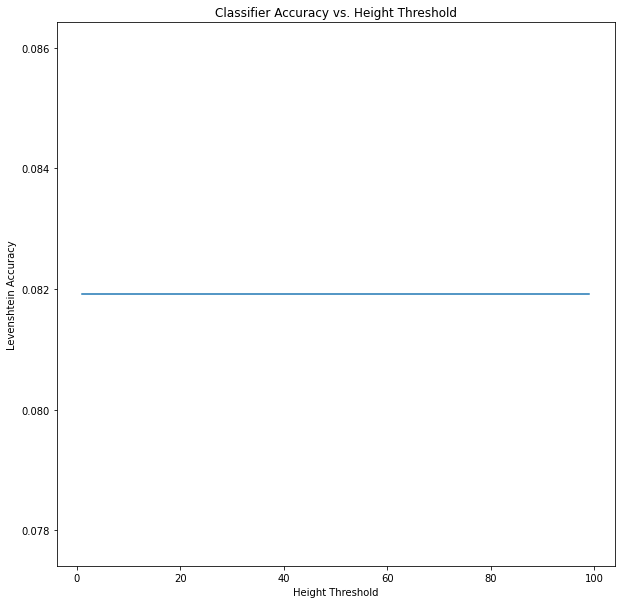

In [6]:
#print(all_accuracies)
plt.figure(figsize=(10, 10))
plt.plot(all_accuracies.keys(), all_accuracies.values())
plt.ylabel("Levenshtein Accuracy")
plt.xlabel("Height Threshold")
plt.title("Classifier Accuracy vs. Height Threshold")

In [9]:
best_heights = []
best_value = 0
for value in all_accuracies.values():
    if round(value, 5) > round(best_value, 5):  #need to round because python maintains its floats very imprecisly
        best_value = value

for key, value in all_accuracies.items():
    if round(value, 5) == round(best_value, 5):
        best_heights.append(key)

print("Best height threshold values:", best_heights)
print("Accuracy with best height threshold:", all_accuracies[best_heights[0]])


Best height threshold values: [10, 11, 12, 13, 14, 15]
Accuracy with best height threshold: 0.8649380122419338
